# setups & imports

In [68]:
!pip install rs_metrics lightfm

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
%matplotlib inline

from collections import Counter

import scipy.stats as sts

from datetime import date
from rs_metrics import mapr, ndcg
from copy import deepcopy
from typing import Optional

import abc
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

from scipy.sparse import csr_matrix

from tqdm import tqdm

import gc

In [70]:
songs_df = pd.read_csv('/kaggle/input/ds-2-vk/songs.csv/songs.csv')
song_extra_info_df = pd.read_csv('/kaggle/input/ds-2-vk/song_extra_info.csv/song_extra_info.csv')
members_df = pd.read_csv('/kaggle/input/ds-2-vk/members.csv/members.csv')
train_df = pd.read_csv('/kaggle/input/ds-2-vk/train.csv/train.csv')
test_df = pd.read_csv('/kaggle/input/ds-2-vk/test.csv/test.csv')

# Preprocessing

In [71]:
full_songs_df = songs_df.merge(song_extra_info_df, how='outer')
full_train_df = train_df.merge(full_songs_df, how='left', on='song_id')
full_train_df = full_train_df.merge(members_df, how='left', on='msno')

In [72]:
full_test_df = test_df.merge(full_songs_df, how='left', on='song_id')
full_test_df = full_test_df.merge(members_df, how='left', on='msno')
full_test_df.rename(columns={"index":"interaction_id"}, inplace=True)

In [73]:
full_train_df = full_train_df.dropna(subset=['msno', 'song_id'])
full_test_df = full_test_df.dropna(subset=['msno', 'song_id'])
df = pd.concat([full_train_df, full_test_df]).reset_index()

encoder = LabelEncoder()

df['user_id'] = encoder.fit_transform(df['msno'])
df['item_id'] = encoder.fit_transform(df['song_id'])

interactions_df = df[train_df.columns.to_list() + ['user_id', 'item_id']]
interactions_df.drop(['msno', 'song_id'], axis=1, inplace=True)
interactions_df.reset_index(inplace=True)
interactions_df.rename(columns={'index': 'interaction_id'}, inplace=True)

u_features = df[members_df.columns.to_list() + ['user_id']].drop_duplicates('msno')
u_features.drop(['msno'], axis=1, inplace=True)

i_features = df[full_songs_df.columns.to_list() + ['item_id']].drop_duplicates('song_id')
i_features.drop(['song_id'], axis=1, inplace=True)

In [74]:
encoder = LabelEncoder()

categorical_columns = interactions_df.drop(['interaction_id', 'user_id', 'item_id'], axis=1).select_dtypes(include=['object']).columns

for col in categorical_columns:
    interactions_df[col] = encoder.fit_transform(interactions_df[col].fillna('nan'))

display(interactions_df)

,interaction_id,source_system_tab,source_screen_name,source_type,target,user_id,item_id
0,0,1,7,7,1.0,9176,86884
1,1,3,8,4,1.0,19273,260594
2,2,3,8,4,1.0,19273,140755
3,3,3,8,4,1.0,19273,27577
4,4,1,7,7,1.0,9176,38706
...,...,...,...,...,...,...,...
9934203,9934203,0,11,7,NaN,19206,396079
9934204,9934204,0,22,7,NaN,25753,146146
9934205,9934205,0,22,7,NaN,25753,409892
9934206,9934206,0,22,7,NaN,25753,226660


Удалим объекты и пользователей менее чем с 5 взаимодействиями, поскольку качество коллаборативных моделей для пользователей и айтемов с небольшим числом взаимодействий с большой вероятностью будет низким.

In [75]:
item_counts = interactions_df[~interactions_df.target.isna()].groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 1]
filtered_df = interactions_df[~interactions_df.target.isna()][interactions_df[~interactions_df.target.isna()]['item_id'].isin(pop_items.index)]

In [76]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 1]
filtered_df = filtered_df[df['user_id'].isin(pop_users.index)].copy()

/tmp/ipykernel_191/551653281.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[df['user_id'].isin(pop_users.index)].copy()


Разобьем датасет на train и test по времени, взяв 20% наиболее свежих взаимодействий в test.

In [77]:
train_by_date = filtered_df[filtered_df['interaction_id'] <= filtered_df['interaction_id'].quantile(0.8)]
test_by_date = filtered_df[filtered_df['interaction_id'] > filtered_df['interaction_id'].quantile(0.8)]

In [78]:
counts_in_test = test_by_date.groupby('user_id')['item_id'].count()
test_by_date = test_by_date[test_by_date['user_id'].isin(counts_in_test[counts_in_test > 4].index)].copy()
test_by_date['rank'] = test_by_date.groupby('user_id')['interaction_id'].rank(method="first", ascending=True)
test_by_date = test_by_date[test_by_date['rank'] <= 5].drop(columns=['rank'])

# удалим холодных пользователей
test_by_date = test_by_date[test_by_date['user_id'].isin(train_by_date['user_id'].unique())]
test_by_date_users = test_by_date['user_id'].drop_duplicates()

In [79]:
i_features_filtered = i_features[i_features['item_id'].isin(filtered_df['item_id'].unique())].copy()
u_features_filtered = u_features[u_features['user_id'].isin(filtered_df['user_id'].unique())].copy()

In [80]:
test_by_date

,interaction_id,source_system_tab,source_screen_name,source_type,target,user_id,item_id
5900118,5900118,0,11,7,1.0,6457,136095
5900119,5900119,0,11,7,1.0,6457,198975
5900122,5900122,7,0,0,1.0,29661,10149
5900123,5900123,7,0,0,1.0,29661,380038
5900124,5900124,7,0,0,0.0,29661,251994
...,...,...,...,...,...,...,...
7376203,7376203,0,3,7,0.0,32667,275905
7376204,7376204,0,3,7,0.0,32667,246719
7376205,7376205,0,3,7,0.0,32667,342272
7376206,7376206,0,3,7,0.0,32667,360541


In [81]:
del song_extra_info_df
del songs_df
del train_df
del test_df
del full_train_df
del full_test_df

In [82]:
gc.collect()
gc.collect()

0

# Metrics

Применим ряд метрик, помимо заданной по заданию, для более четкой оценки конкретной моделе, например - насколько новые треки в рекомендации предлагает модель.

In [83]:
K=20

In [84]:
def user_hr(row):
    """
    Calculate HitRate value for pandas row with user_id, a list of ground truth items in ``gt_items``
    and list or recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [85]:
def user_mrr(row):
    """
    Calculate MRR value for pandas row with list of ground truth items in ``gt_list``
    and list or recommended items in ``pred_list``.
    """
    for rank, item in enumerate(row['pred_list']):
        if item in row['gt_list']:
            return 1 / (rank + 1)
    return 0

In [86]:
def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

In [87]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.num_users = log['user_id'].nunique()
        self.item_pop = (log.groupby('item_id')[['user_id']].count() / self.num_users).rename(columns={'user_id':'rel'})

    def __call__(self, pred, k):
        """
        Calculate Surprisal value for ``pred`` with pre-calculated items' popularity
        """
        top_k_recs = leave_top_k(pred, k)
        matrix = top_k_recs[['item_id', 'user_id']].merge(self.item_pop, left_on='item_id', right_index=True, how='left').fillna(1 / self.num_users)
        matrix.loc[:, 'rel'] = - np.log2(matrix['rel'])
        user_self_inf = matrix.groupby('user_id')['rel'].sum()
        user_self_inf /= k * np.log2(self.num_users)
        return user_self_inf.mean()

In [88]:
surp = Surprisal(train_by_date)

In [89]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').
    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    # оставляем первые k рекомендаций
    pred_cropped = leave_top_k(pred, k)
    # собираем list-ы
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # применяем метрику
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [90]:
def measure(pred, true, name, df=None, cov_items=None, surp=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@1', 'hit_rate@K', 'map@K', 'ndcg@K', 'coverage@K', 'surprisal@K'])
    df.loc[name, 'hit_rate@1'] = metric_wrap(pred=pred, ground_truth=true, k=1, metric_by_user=user_hr)[0]
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'map@K'] = mapr(true=true, pred=pred, k=K)
    df.loc[name, 'ndcg@K'] = ndcg(true=true, pred=pred, k=K)

    if cov_items is not None:
        df.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    if surp is not None:
        df.loc[name, 'surprisal@K'] = surp(pred=pred, k=K)
    return df

In [91]:
gc.collect()
gc.collect()

0

# Baseline(Recommend Popular model)

В качестве моделе возьмем самую простую модель — модель, которая будет рекомендовать популярные треки (треки, которые чаще всего слушали). Построим такую модель.

In [92]:
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
popularity /= train_by_date['user_id'].nunique()

In [93]:
pd.DataFrame(popularity).merge(i_features_filtered, on='item_id').head(10)

,item_id,popularity,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,365248,0.455081,219324.0,458,周湯豪 (NICKTHEREAL),周湯豪,周湯豪\崔惟楷,3.0,帥到分手,TWAG11600306
1,204493,0.433710,215144.0,458,周杰倫 (Jay Chou),周杰倫,方文山,3.0,告白氣球,TWK971601308
2,118074,0.421781,287328.0,458,Eric 周興哲,Eric Chou,Eric Chou| Yi-Wei Wu,3.0,你，好不好？ (How Have You Been?),TWA471602002
3,395262,0.417463,265508.0,465,田馥甄 (Hebe),JerryC,徐世珍/吳輝福,3.0,小幸運 (A little happiness),TWD951562101
4,181909,0.395616,227343.0,465,謝和弦 (R-chord),R-chord,R-chord,3.0,謝謝妳愛我 (Thanks For Your Love),TWA531657203
5,238767,0.385187,185295.0,451,陳奕迅 (Eason Chan),Tang Han Xiao,Tang Han Xiao,3.0,讓我留在你身邊,HKJ631603001
6,211063,0.377319,290063.0,458,周杰倫 (Jay Chou),周杰倫,方文山,3.0,不該,TWK971601306
7,159035,0.372489,265848.0,465,林俊傑 (JJ Lin),JJ Lin,Lin Qiu Li,3.0,不為誰而作的歌 (Twilight),TWA531576502
8,40286,0.362645,346272.0,458,五月天 (Mayday),怪獸,阿信,3.0,後來的我們 (Here| After| Us),TWK231610206
9,268835,0.343323,250357.0,458,五月天 (Mayday),阿信,阿信,3.0,派對動物 (Party Animal),TWK231680790


In [94]:
def leave_top_k(pred: pd.DataFrame,
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred


def filter_seen_items(log: pd.DataFrame,
                 pred: pd.DataFrame) -> pd.DataFrame:
    """
    filter pairs `user-item` present in log out of pred
    """
    log_filtered = log[log['user_id'].isin(pred['user_id'].unique())]
    pred = pred.merge(log_filtered[['user_id', 'item_id']].drop_duplicates(),
                                on=['user_id', 'item_id'],
                                how='outer',
                                indicator = True)
    return pred[pred['_merge'] == 'left_only'].drop(columns=['_merge'])


class ParentModel:
    @abc.abstractmethod
    def fit(self,
            log: pd.DataFrame,
            user_features: Optional[pd.DataFrame]=None,
            item_features: Optional[pd.DataFrame]=None):
        """
        fit recommender

        Parameters
        ----------
        log : pandas dataframe with columns [user_id, item_id, timestamp, relevance]
        user_features : pandas dataframe with column `user_id` and features columns
        item_features : pandas dataframe with column `item_id` and features columns

        Returns
        -------

        """


    def predict(self,
                log: pd.DataFrame,
                users: pd.Series,
                k: int,
                user_features: Optional[pd.DataFrame]=None,
                item_features: Optional[pd.DataFrame]=None,
                filter_seen: bool = True) -> pd.DataFrame:
        """
        predict with fitted model, filter seen and crop to top-k for each user

        Parameters
        ----------
        log: pandas dataframe with columns [user_id, item_id, timestamp, relevance]
            used to filter seen and to make predictions by some models
        users: user ids to recommend for
        k: number of recommendations for each user
        user_features: pandas dataframe with column `user_id` and features columns
        item_features: pandas dataframe with column `item_id` and features columns
        filter_seen: if True, items present in user history are filtered from predictions

        Returns
        -------
        pandas dataframe with columns [user_id, item_id, relevance]
            top-k recommended items for each user from `users`.
        """

        # overhead
        max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0

        pred = self._predict(
            log=log,
            users=users,
            k=max_items_in_train+k,
            user_features=user_features,
            item_features=item_features,
            filter_seen=filter_seen)
        if filter_seen:
            pred = filter_seen_items(log, pred)

        return leave_top_k(pred, k)


    @abc.abstractmethod
    def _predict(self,
                log: pd.DataFrame,
                users: pd.Series,
                k: int,
                user_features: Optional[pd.DataFrame]=None,
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        """
        predict with fitted model
        """

In [95]:
class PopularModel(ParentModel):
    items_popularity: pd.DataFrame

    def fit(self,
            log: pd.DataFrame,
            user_features: Optional[pd.DataFrame]=None,
            item_features: Optional[pd.DataFrame]=None) -> 'PopularModel':

        self.items_popularity = log.groupby('item_id')['user_id'].count().sort_values(ascending=False).rename('popularity') / log['user_id'].nunique()
        return self

    def _predict(self,
                log: pd.DataFrame,
                users: pd.Series,
                k: int,
                user_features: Optional[pd.DataFrame]=None,
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:

        users_to_join = pd.DataFrame(users)
        users_to_join['key'] = 0
        pred = pd.DataFrame({'item_id': self.items_popularity[:k].index.to_list(),
                     'relevance': self.items_popularity[:k].values})
        pred['key'] = 0
        return users_to_join.merge(pred, on='key', how='outer').drop(columns=['key']).reset_index(drop=True)

In [96]:
%%time
rec = PopularModel()
rec.fit(train_by_date)

CPU times: user 288 ms, sys: 822 µs, total: 289 ms
Wall time: 288 ms


In [97]:
pred = rec.predict(log=train_by_date, users=test_by_date_users, k=K, filter_seen=True)

/tmp/ipykernel_191/2434742960.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0


In [98]:
pred.head(11)

,user_id,item_id,relevance
19,0,2498,0.245911
30,0,3221,0.323819
84,0,7509,0.265488
390,0,36546,0.272368
613,0,59992,0.332162
926,0,87569,0.285469
1028,0,96964,0.249167
1228,0,118074,0.421781
1394,0,133878,0.319062
1591,0,152285,0.255352


In [99]:
assert pred.shape[0] == test_by_date_users.shape[0] * K
assert (pred.groupby('user_id')['item_id'].count() == K).all()
assert pred['item_id'].nunique() > K

In [100]:
%%time
metrics = measure(pred, test_by_date, 'popular', cov_items=filtered_df['item_id'], surp=surp)
metrics

CPU times: user 13.1 s, sys: 441 ms, total: 13.5 s
Wall time: 14.5 s


,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
popular,0.031257,0.192047,0.010794,0.031517,0.001449,0.122557


In [101]:
del rec
del pred

In [102]:
gc.collect()
gc.collect()

0

# LightFM

In [103]:
%%time
u_features_filtered.set_index('user_id', inplace=True)
u_features_list = u_features_filtered.apply(lambda x: ['{}_{}'.format(value,x[value]) for value in x.index if not pd.isna(x[value])], axis=1)
u_features_list = u_features_list.rename('features')

CPU times: user 2.33 s, sys: 8.81 ms, total: 2.34 s
Wall time: 2.34 s


In [104]:
u_features_list[TEST_USER]

['city_1',
 'bd_0',
 'registered_via_4',
 'registration_init_time_20161211',
 'expiration_date_20161214']

In [105]:
unique_user_tags = set(u_features_list.explode().dropna().values)

In [106]:
i_features_lfm = i_features_filtered.copy()
i_features_lfm.set_index('item_id', inplace=True)
i_features_lfm['listens'] = filtered_df.groupby('item_id')['user_id'].count()
i_features_lfm.loc[:, 'listens'].fillna(0, inplace=True)
i_features_lfm.loc[:, 'genre_ids'] = i_features_lfm['genre_ids'].str.lower().str.split(',').apply(lambda x: x if isinstance(x, list) else [])
i_features_lfm.loc[:, 'genre_ids'] = i_features_lfm.loc[:, 'genre_ids'].apply(lambda g_list: [genre.strip() for genre in g_list])

/tmp/ipykernel_191/2336675701.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  i_features_lfm.loc[:, 'listens'].fillna(0, inplace=True)


In [107]:
i_features_lfm

,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,listens
item_id,,,,,,,,,
86884,206471.0,[359],Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,215
140755,225396.0,[1259],Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,4
38706,187802.0,[1011],Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,412
35087,247803.0,[1259],Desiigner,Sidney Selby| Adnan Khan,NaN,52.0,Panda,USUM71601094,1108
221459,229982.0,[465],BIGBANG TAEYANG,TEDDY| DEE.P| Rebecca Johnson,TEDDY| TAEYANG,31.0,眼| 鼻| 口 (Eyes| Nose| Lips),TWA531400512,3869
...,...,...,...,...,...,...,...,...,...
142702,203778.0,[359],Imagine Dragons,Dan Reynolds| Wayne Sermon| Ben McKee| Daniel ...,NaN,52.0,Believer,USUM71700626,7
219193,339069.0,[465],証聲音樂圖書館 ECHO MUSIC,Jeremy Mage,NaN,52.0,YACHT ROCK,NaN,2
72891,213133.0,[1259],Missy Elliott,NaN,NaN,52.0,I'm Better (feat. Lamb),USEE11700002,2


In [108]:
TEST_SONG = 86884

In [109]:
i_features_lfm.loc[TEST_SONG]

song_length                206471.0
genre_ids                     [359]
artist_name                Bastille
composer       Dan Smith| Mark Crew
lyricist                        NaN
language                       52.0
name                     Good Grief
isrc                   GBUM71602854
listens                         215
Name: 86884, dtype: object

In [110]:
genres_count = i_features_lfm[['genre_ids', 'listens']].explode('genre_ids').groupby('genre_ids')['listens'].sum()
genres_count.sort_values(ascending=False)

genre_ids
465                           3666670
458                           1258877
921                            344097
1609                           302270
444                            241914
                               ...   
1266                                2
873|958                             2
1152|947|2086|374|2122|958          2
921|139                             2
1000                                2
Name: listens, Length: 442, dtype: int64

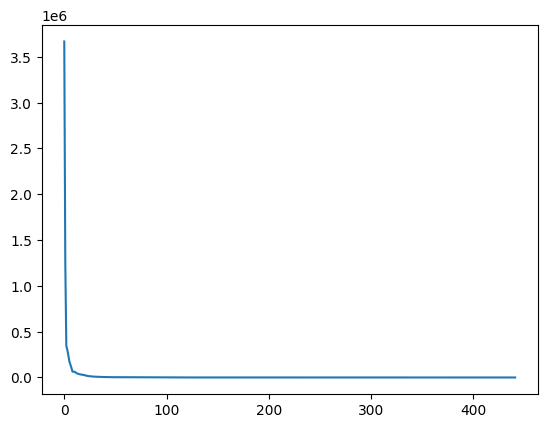

In [111]:
genres_count.sort_values(ascending=False).reset_index(drop=True).plot();

In [112]:
unique_item_tags = genres_count.sort_values(ascending=False)[:20].index
unique_item_tags[:10]

Index(['465', '458', '921', '1609', '444', '1259', '2022', '359', '2122',
       '139'],
      dtype='object', name='genre_ids')

In [113]:
def filter_genres(genres_list, valid_genres=None):
    if not genres_list:
        return []
    return [genre for genre in genres_list if genre in valid_genres]

In [114]:
%%time
i_features_lfm['features'] = i_features_lfm['genre_ids'].apply(filter_genres, valid_genres=set(unique_item_tags))

CPU times: user 652 ms, sys: 1.95 ms, total: 654 ms
Wall time: 652 ms


In [115]:
i_features_list = i_features_lfm['features']
i_features_list.loc[TEST_SONG]

['359']

In [116]:
lfm_dataset = LFMDataset()

In [117]:
lfm_dataset.fit_partial(users=filtered_df['user_id'].unique(), items=filtered_df['item_id'].unique())
lfm_dataset.fit_partial(user_features=unique_user_tags, item_features=unique_item_tags)

In [118]:
user_mapping, item_mapping = lfm_dataset.mapping()[0], lfm_dataset.mapping()[2]

In [119]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

In [120]:
TEST_SONG_LFM = item_mapping[TEST_SONG]

In [121]:
lfm_dataset.interactions_shape()

(29784, 193199)

In [122]:
sparse_i_features = lfm_dataset.build_item_features([[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()])
sparse_u_features = lfm_dataset.build_user_features([[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()])

In [123]:
sparse_i_features.shape

(193199, 193219)

In [124]:
sparse_i_features[1]

<1x193219 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Compressed Sparse Row format>

In [125]:
i_features_list[TEST_SONG]

['359']

In [126]:
sparse_i_features[TEST_SONG_LFM, :].nonzero(), sparse_i_features[TEST_SONG_LFM, :].data

((array([0, 0], dtype=int32), array([     0, 193206], dtype=int32)),
 array([0.5, 0.5], dtype=float32))

In [127]:
%%time
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, row.target) for row in train_by_date.itertuples()])

CPU times: user 36.7 s, sys: 583 ms, total: 37.3 s
Wall time: 37.3 s


In [128]:
interactions.shape, interactions.data

((29784, 193199), array([1, 1, 1, ..., 1, 1, 1], dtype=int32))

In [129]:
SEED=42

In [130]:
%%time
lightfm = LightFM(no_components=64, loss='warp', random_state=SEED, user_alpha=1e-5, item_alpha=1e-5)
lightfm.fit(interactions, user_features=sparse_u_features, item_features=sparse_i_features, epochs=100, num_threads=8)

CPU times: user 2h 1min 56s, sys: 3.93 s, total: 2h 2min
Wall time: 32min 18s


In [131]:
pred = lightfm.predict(user_ids=user_mapping[TEST_USER], item_ids=sorted(item_mapping.values()), user_features=sparse_u_features, item_features=sparse_i_features)

In [132]:
ids = np.argpartition(pred, -K)[-K:]
rel = pred[ids]
res = pd.DataFrame(zip(ids, rel), columns=['item_id', 'relevance'])
res['item_id'] = res['item_id'].map(inv_item_mapping)

In [136]:
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features_filtered.merge(popularity, right_index=True, left_on="item_id")

In [137]:
res.merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,popularity
16,238767,-131.540619,185295.0,451,陳奕迅 (Eason Chan),Tang Han Xiao,Tang Han Xiao,3.0,讓我留在你身邊,HKJ631603001,10526
18,365248,-131.575272,219324.0,458,周湯豪 (NICKTHEREAL),周湯豪,周湯豪\崔惟楷,3.0,帥到分手,TWAG11600306,12436
19,387355,-131.742783,161175.0,1616|1609,Alan Walker,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,52.0,Alone,NOG841617010,8901
14,138868,-131.859497,212750.0,1616|1609,Alan Walker,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,52.0,Faded,NOG841549010,9314
17,204493,-131.890335,215144.0,458,周杰倫 (Jay Chou),周杰倫,方文山,3.0,告白氣球,TWK971601308,11852
15,118074,-131.901779,287328.0,458,Eric 周興哲,Eric Chou,Eric Chou| Yi-Wei Wu,3.0,你，好不好？ (How Have You Been?),TWA471602002,11526
13,181909,-131.963562,227343.0,465,謝和弦 (R-chord),R-chord,R-chord,3.0,謝謝妳愛我 (Thanks For Your Love),TWA531657203,10811
11,133878,-131.967712,244976.0,1609,The Chainsmokers,Andrew Taggart| Shaun Frank| Frederic Kennett|...,Andrew Taggart| Shaun Frank| Frederic Kennett|...,52.0,Closer,USQX91601347,8719
6,395262,-132.056549,265508.0,465,田馥甄 (Hebe),JerryC,徐世珍/吳輝福,3.0,小幸運 (A little happiness),TWD951562101,11408
8,40286,-132.076004,346272.0,458,五月天 (Mayday),怪獸,阿信,3.0,後來的我們 (Here| After| Us),TWK231610206,9910


In [138]:
item_id_lfm = item_mapping[TEST_SONG]
user_id_lfm = user_mapping[TEST_USER]

In [139]:
rel = lightfm.predict(user_ids=user_id_lfm,
                      item_ids=[item_id_lfm],
                      user_features=sparse_u_features,
                      item_features=sparse_i_features)[0]
rel

-134.82616

In [140]:
u_biases, u_vectors = lightfm.get_user_representations()
u_vectors.shape, u_biases.shape

((35071, 64), (35071,))

In [141]:
i_biases, i_vectors =lightfm.get_item_representations()
i_vectors.shape, i_biases.shape

((193219, 64), (193219,))

In [142]:
user_vector = sparse_u_features[user_id_lfm]@u_vectors
item_vector = sparse_i_features[item_id_lfm]@i_vectors
rel_ours = (user_vector@item_vector.T + sparse_u_features[user_id_lfm]@u_biases + sparse_i_features[item_id_lfm]@i_biases).ravel()[0]

In [143]:
assert math.isclose(rel, rel_ours, rel_tol=1e-5)

In [144]:
from typing import Dict, Iterable
class UserFriendlyLightFM(SVDModel):
    user_mapping: Dict
    item_mapping: Dict
    inv_user_mapping: Dict
    inv_item_mapping: Dict
    lightfm_dataset: LFMDataset

    def __init__(self,
                 user_ids: np.ndarray,
                 item_ids: np.ndarray,
                 user_tags: Optional[Iterable],
                 item_tags: Optional[Iterable],
                 epochs: int,
                 model: LightFM
                ):
        self.lightfm_dataset = LFMDataset()
        self.lightfm_dataset.fit(users=user_ids,
                                         items=item_ids,
                                         user_features=user_tags,
                                         item_features=item_tags,
                                        )
        self.user_mapping = self.lightfm_dataset.mapping()[0]
        self.item_mapping = self.lightfm_dataset.mapping()[2]
        self.inv_user_mapping = {value: key for key, value in self.user_mapping.items()}
        self.inv_item_mapping = {value: key for key, value in self.item_mapping.items()}
        self.epochs = epochs
        self.model = model


    def _transform_dataset(self,
                           log: Optional[pd.DataFrame],
            user_features: Optional[pd.DataFrame]=None,
            item_features: Optional[pd.DataFrame]=None):

        (interactions, weights) = self.lightfm_dataset.build_interactions([(row.user_id, row.item_id, row.target) for row in log.itertuples()]) if log is not None else (None, None)
        user_features_sparse = self.lightfm_dataset.build_user_features([[row.user_id, row.features] for row in user_features.reset_index().itertuples()]) if user_features is not None else None
        item_features_sparse = self.lightfm_dataset.build_item_features([[row.item_id, row.features] for row in item_features.reset_index().itertuples()]) if item_features is not None else None
        return interactions, weights, user_features_sparse, item_features_sparse

    def fit(self,
            log: pd.DataFrame,
            user_features: Optional[pd.DataFrame]=None,
            item_features: Optional[pd.DataFrame]=None) -> 'UserFriendlyLightFM':

        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(log, user_features, item_features)
        self.model.fit(interactions, user_features=user_features_sparse, item_features=item_features_sparse, epochs=self.epochs, num_threads=8)
        return self

    def _predict(self,
                log: pd.DataFrame,
                users: pd.Series,
                k: int,
                user_features: Optional[pd.DataFrame]=None,
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:

        pred = pd.DataFrame(users.map(self.user_mapping).unique(), columns=['user_id'])
        pred.dropna(inplace=True)
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(None, user_features, item_features)


        def _get_lfm_pred_all_items(user_id):
            pred_for_all = self.model.predict(user_ids=user_id, item_ids=sorted(self.item_mapping.values()), user_features=user_features_sparse, item_features=item_features_sparse)
            ids = np.argpartition(pred_for_all, -k)[-k:]
            rel = pred_for_all[ids]
            return list(zip(ids, rel))

        pred['recs'] = pred['user_id'].apply(_get_lfm_pred_all_items)
        pred = pred.explode('recs')
        self._split_pair(pred)
        pred['item_id'] = pred['item_id'].map(self.inv_item_mapping)
        pred['user_id'] = pred['user_id'].map(self.inv_user_mapping)
        return pred

# LightFM без признаков

In [145]:
lfm = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(),
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=40,
                             model=LightFM(no_components=64, loss='warp'))

In [146]:
%%time
lfm.fit(log=train_by_date, user_features=None, item_features=None)

CPU times: user 28min 46s, sys: 2.44 s, total: 28min 48s
Wall time: 8min 14s


In [147]:
%%time
lfm_pred = lfm.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=None, item_features=None)

/tmp/ipykernel_191/2434742960.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0


CPU times: user 32min 47s, sys: 46.8 s, total: 33min 34s
Wall time: 33min 32s


In [148]:
%%time
metrics = measure(lfm_pred, test_by_date, 'LightFM_rec_64_40_ep', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('ndcg@K', ascending=False)
metrics

CPU times: user 14.1 s, sys: 471 ms, total: 14.5 s
Wall time: 17.3 s


,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
LightFM_rec_64_40_ep,0.028977,0.224249,0.013017,0.036863,0.080321,0.236793
popular,0.031257,0.192047,0.010794,0.031517,0.001449,0.122557


# LightFM  c признаками

In [157]:
lfm_uf = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(),
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=20,
                             model=LightFM(no_components=128, loss='warp')
                            )

In [158]:
%%time
lfm_uf.fit(log=train_by_date, item_features=i_features_list, user_features=u_features_list)

CPU times: user 47min 1s, sys: 2.27 s, total: 47min 4s
Wall time: 12min 45s


In [159]:
%%time
pred_feat = lfm_uf.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=u_features_list, item_features=i_features_list)

/tmp/ipykernel_191/2434742960.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0


CPU times: user 1h 31min 10s, sys: 1min 7s, total: 1h 32min 18s
Wall time: 1h 32min 22s


In [160]:
%%time
metrics = measure(pred_feat, test_by_date, 'LightFM_rec_features_128_20', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('ndcg@K', ascending=False)
metrics

CPU times: user 14.1 s, sys: 525 ms, total: 14.6 s
Wall time: 17.4 s


,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
LightFM_rec_64_40_ep,0.028977,0.224249,0.013017,0.036863,0.080321,0.236793
LightFM_rec_features_128_20,0.026974,0.200612,0.011225,0.032445,0.0222,0.176424
popular,0.031257,0.192047,0.010794,0.031517,0.001449,0.122557


**Вывод:** наиболее качественные рекомендации и по метрике и по смылу выдает модель LigthFM без признаков, что можно заметить как по примерам рекомендации для отдельного пользователя, так и в датафрэйме metrcis. Что касается возможности улучшить полученный результат, то можно увеличить количество фичей, число эпох обучения или присмотреться к двухуровневой модели, где на фичах lightfm будет обучаться XGBoost или Catboost классификатором, в котором подбор параметров осуществляется с помощью optuna.